# Alaska IfSAR Dataset Processing for Streamline Delineation

This notebook provides a comprehensive guide to processing and utilizing the Alaska IfSAR dataset for streamline delineation tasks. The Alaska IfSAR dataset, developed by the U.S. Geological Survey (USGS), contains high-resolution geospatial data that includes various terrain, hydrological, and environmental features critical for analyzing water flow across Alaska’s diverse landscape. Using these data layers, we can automate the process of delineating streamlines — an essential task for applications in hydrology, flood modeling, and environmental monitoring.

### Objectives

In this notebook, we will cover the full workflow, from data preparation to model training, including:

1. **Data Description**: An overview of the various layers in the Alaska IfSAR dataset, each representing distinct features such as elevation, topographic indices, and hydrological characteristics.
2. **Data Processing**: Steps for extracting and normalizing relevant data layers, stacking them into multi-channel arrays, and generating labeled patches for machine learning.
3. **Example Usage**: A demonstration of training a simple machine learning model to predict streamline locations, showcasing the model’s ability to learn patterns in the processed data.

### Why Streamline Delineation?

Streamline delineation is essential for understanding water flow in terrain, supporting tasks such as flood prediction, watershed management, and ecological studies. However, manual delineation can be time-consuming and error-prone, especially over vast regions like Alaska. By leveraging machine learning with high-resolution datasets like Alaska IfSAR, we can automate and enhance this process, providing a scalable solution for hydrological analysis.

This notebook is designed to guide you through each step of the process, from data handling and preprocessing to building and evaluating a machine learning model for streamline delineation. By the end, you’ll have a structured dataset and a foundational model that you can expand upon for more complex geospatial analyses.
l analysis!


In [77]:
%%capture
# run this block to install all required libraries. 
!pip install rasterio ipywidgets geopandas matplotlib contextily tensorflow ;

# Table of Contents
1. [Introduction](#Introduction)
2. [Data Description](#Data-Description)
3. [Data Processing](#Data-Processing)
4. [Example Usage](#Example-Usage)

----

## Introduction


This Jupyter Notebook provides a comprehensive guide for processing geospatial data from the Alaska IfSAR dataset, developed by the U.S. Geological Survey (USGS). This dataset contains high-resolution raster files that include various terrain, hydrological, and environmental features crucial for understanding and modeling water flow across Alaska’s diverse landscape. By automating the data processing workflow, we aim to prepare this data for machine learning tasks, particularly in streamline delineation and hydrological modeling.

For the purposes of this tutorial, we will focus on a single watershed as an example: **Watershed 190603010302**. This watershed contains various geospatial layers that provide detailed information on topography, water flow, and hydrographic boundaries. These layers will help us demonstrate key data processing steps, from patch extraction to the preparation of input data for machine learning models.

Using this notebook, you will:
1. Learn about the different types of data available in the Alaska IfSAR dataset.
2. Follow the data processing steps applied to watershed `190603010302`.
3. Explore example usage for preparing data patches suitable for hydrological analysis and streamline delineation tasks.

This introduction sets the stage for an in-depth walkthrough of the data, including explanations of each geospatial layer and their role in the analysis. Let's dive into the `Data Description` section to explore the contents of the dataset!

### Why Streamline Delineation?
Streamline delineation is critical for applications such as riverine navigation, water resource management, and flood risk modeling. However, the task is complex, with challenges including spatial heterogeneity, ambiguous flow paths, and computational intensity. Traditional methods often fall short in capturing the nuanced characteristics of water flow, especially across vast and variable landscapes like Alaska. Machine learning offers a promising approach to automate and enhance this process.


## Data Description


The `data` folder contains a variety of raster and vector files representing different geospatial characteristics of the Alaska IfSAR dataset. Each file captures unique terrain, hydrological, and environmental features critical for hydrological modeling and streamline delineation. Below is an outline of the key types of files included:

- **Reference File**:
  - `190603010302_filtered_ref_1m_minbuf.tif`: This file serves as the reference data for the dataset. It is a high-resolution rasterized version of hydrographic features from the USGS National Hydrography Dataset (NHD). It includes features such as rivers, lakes, and stution, providing an accurate baseline for water bodies within the study area.

- **Elevation Models**:
  - `dsm_*.tif` and `dtm_*.tif`: Represent Digital Surface Model (DSM) and Digital Terrain Model (DTM), providing surface and bare-earth elevation data, respectively.
  - `nlf_dtm_*.tif`: A filtered version of the DTM, often used to refine terrain analysis.

- **Hydrological Features**:
  - `swm1_*.tif`, `swm2_*.tif`: Shallow Water Models that simulate water flow paths and drainage patterns.
  - `swmdis1_*.tif`, `swmdis2_*.tif`: Additional shallow water drainage models with distance-based calculations for flow path identification.
  - `twi_*.tif`: Topographic Wetness Index, which indicates soil moisture and water accumulation areas, essential for understanding water flow in terrain.

- **Topographic Indices and Surface Characteristics**:
  - `curvature_*.tif`: Represents the curvature of the terrain, useful for identifying ridges and valleys.
  - `tpi_1_*.tif`, `tpi_3_*.tif`: Topographic Position Index at different scales, aiding in the identification of terrain features like peaks, plains, and valleys.
  - `pos_openness_*.tif` and `neg_openness_*.tif`: Measure terrain openness, highlighting exposed or sheltered areas.
  - `sky_view_factor_*.tif` and `sky_illum_*.tif`: Assess the openness of terrain to the sky, relevant for shadow analysis and vegetation studies.

- **Hydro Region Boundary**:
  - `hydro_region_*.shp` (along with `.dbf`, `.prj`, and `.shx` files): A shapefile defining the hydrological boundaries within the dataset, including attribute information, spatial projection, and geometry. These boundaries represent distinct hydrological regions based on watershed division.

- **Geomorphological Features**:
  - `geomorph_*.tif`: Represents landform characteristics, which are critical for understanding the physical geography of the region and its effect on water flow.

Each of these files is named with a unique identifier, often incorporating the Hydrologic Unit Code (HUC) for specific watersheds, facilitating the organization and retrieval of data for targeted analyses.


### Let's visualize the GeoTIFF image data

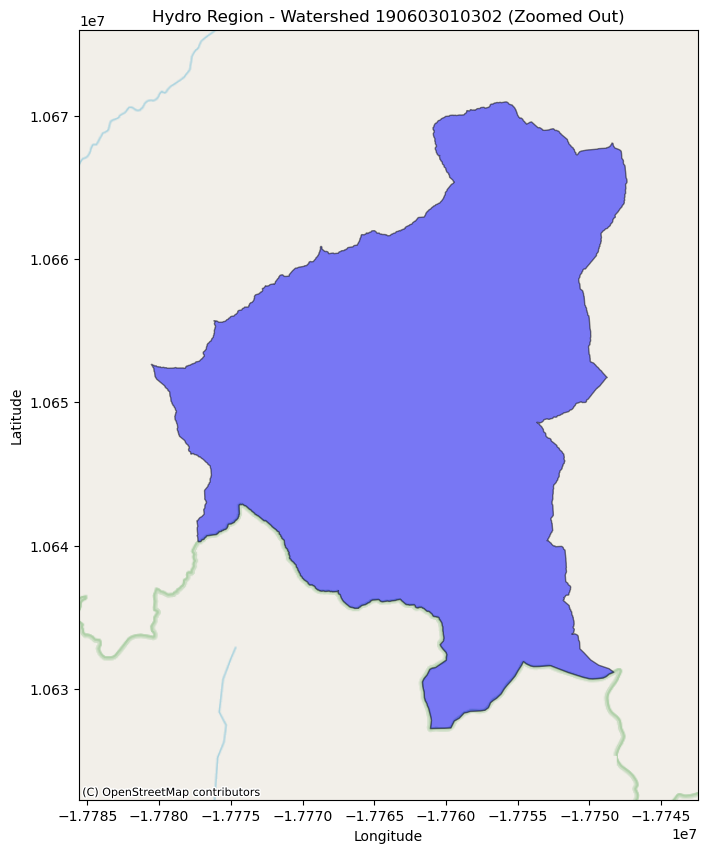

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Load the shapefile
shapefile_path = "data/hydro_region_190603010302.shp"  # replace with your shapefile path
gdf = gpd.read_file(shapefile_path)

# Reproject to Web Mercator for compatibility with contextily
gdf = gdf.to_crs(epsg=3857)

# Create a buffered version of the GeoDataFrame to add space around the shape
buffered_gdf = gdf.buffer(5000)  # Adjust the buffer size (in meters) to zoom out

# Plot with basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original shapefile and the buffer
gdf.plot(ax=ax, color="blue", edgecolor="black", alpha=0.5)
# buffered_gdf.plot(ax=ax, color="none", edgecolor="red", linestyle="--")  # Optional: Show buffer boundary for reference

# Set the extent to the buffered bounds
ax.set_xlim(buffered_gdf.total_bounds[0], buffered_gdf.total_bounds[2])
ax.set_ylim(buffered_gdf.total_bounds[1], buffered_gdf.total_bounds[3])

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Hydro Region - Watershed 190603010302 (Zoomed Out)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [4]:
import rasterio  # Library for reading and writing geospatial raster data
from rasterio.plot import show  # Function to easily plot raster data
import matplotlib.pyplot as plt  # Plotting library
from ipywidgets import interact, Dropdown  # Widgets for interactive Jupyter Notebook features
import os 

# Path to your data folder containing the TIFF files
data_folder = "data/"

# List all TIFF files in the data folder
tiff_files = [f for f in os.listdir(data_folder) if f.endswith('.tif')]

# Create a dictionary that maps each TIFF filename to its file path
# This makes it easy to access the file path by filename
tiff_dict = {file: os.path.join(data_folder, file) for file in tiff_files}

def display_tiff(layer):
    """
    Function to display a selected TIFF file layer.

    Parameters:
    - layer: The name of the TIFF file (chosen from the dropdown)
    """
    # Open the selected TIFF file using rasterio
    with rasterio.open(tiff_dict[layer]) as src:
        # Set up the plot with 300 DPI for high resolution
        fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
        # Display the raster data on the plot
        show(src, ax=ax, title=layer)
        # Show the plot
        plt.show()

# Create an interactive dropdown menu with options from the TIFF files
dropdown = Dropdown(options=tiff_files, description="Layer:")

# Use 'interact' to update the display_tiff function whenever the dropdown selection changes
interact(display_tiff, layer=dropdown)

interactive(children=(Dropdown(description='Layer:', options=('curvature_190603010302.tif', 'neg_openness_1906…

<function __main__.display_tiff(layer)>

## Data Processing


In this section, we will go through the key steps required to process the Alaska IfSAR data for watershed `190603010302`. This data processing pipeline prepares raster and vector data for machine learning applications in streamline delineation. The main steps include patch creation and data extraction.

### 1. Patch Creation

The first step is to divide the raster data into smaller, manageable patches. These patches allow us to segment the data spatially, making it feasible to train machine learning models that can identify patterns in water flow and terrain features. For this task, we use a moving window approach with a predefined patch size.

**Steps for Patch Creation**:
1. **Load the Raster Data**: We use the `rasterio` library to read the GeoTIFF files associated with watershed `190603010302`.
2. **Define the Moving Window**: Set the patch size (e.g., 128x128 pixels) and stride to control the overlap between patches.
3. **Validate Patches**: Only keep patches that meet specific criteria, such as containing a certain number of stream pixels or being complete (not containing missing data).
4. **Save Patch Locations**: Record the location (top-left corner) of each valid patch in a text file for later retrieval.

The patch creation step helps to break down the large dataset into smaller, more computationally manageable segments, each containing important hydrological features relevant for mod of the processed data.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import matplotlib.patches as patches

In [29]:
def save_patch_locations(input_raster_path, patch_size, min_ones, huc_code):
    """
    Save the locations of valid patches in a text file and print the first 10 samples.
    """
    output_txt_path = f"{huc_code}.txt"  # Define the output text file path
    patch_locations = []  # List to store patch locations for display

    # Open the raster file
    with rasterio.open(input_raster_path) as src:
        # Read the first band of the raster data
        raster_data = src.read(1)

        # Generate a mask from the dataset
        mask = src.dataset_mask()
        
        # Apply the mask to the raster data
        masked_data = np.where(mask == 255, raster_data, 0)
        
        # Binarize the masked data: Set values > 0 to 1, ignoring -9999 values
        binary_data = np.where((masked_data > 0), 1, 0)
    
    # Get the dimensions of the binary image
    img_height, img_width = binary_data.shape

    # Open the output text file to save patch locations
    with open(output_txt_path, 'w') as file:
        # Loop over the binary data to identify valid patches
        for y in range(0, img_height, patch_size):
            for x in range(0, img_width, patch_size):
                # Define the patch boundaries
                patch = binary_data[y:y+patch_size, x:x+patch_size]
                patch_mask = mask[y:y+patch_size, x:x+patch_size]

                # Check if the patch is complete (fully within the mask)
                if patch.shape == (patch_size, patch_size):
                    # Check if the patch contains at least `min_ones` pixels with value 1
                    if np.sum(patch == 1) >= min_ones:
                        # Save the top-left corner coordinates of the patch to the file
                        file.write(f"{x}, {y}\n")
                        # Add the coordinates to the list for displaying samples
                        patch_locations.append((x, y))

    # Display the first 10 patch locations as a sample
    print(f"Patch locations saved to {output_txt_path}")
    print("First 10 patch locations (x, y):")
    for loc in patch_locations[:10]:
        print(loc)

def plot_patches_from_file(input_raster_path, huc_code, patch_size, dpi=300):
    """
    Plot the patches using locations from the text file.
    """
    output_txt_path = f"{huc_code}.txt"  # Path to the saved patch locations file
    
    # Open the raster file and read the data
    with rasterio.open(input_raster_path) as src:
        # Read and binarize the raster data
        raster_data = src.read(1)
        mask = src.dataset_mask()
        masked_data = np.where(mask == 255, raster_data, 0)
        binary_data = np.where((masked_data > 0), 1, 0)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(5, 5), dpi=dpi)
    ax.imshow(binary_data, cmap='gray', interpolation='none')
    ax.axis('off')  # Remove axis for cleaner visualization

    # Read the patch locations from the file and plot them
    with open(output_txt_path, 'r') as file:
        for line in file:
            x, y = map(int, line.strip().split(','))
            # Draw a bounding box around each patch location
            rect = patches.Rectangle((x, y), patch_size, patch_size,
                                     linewidth=1, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

    # Display the plot
    plt.show()

In [20]:
# Usage example with specific file paths and parameters
input_raster_path = "data/190603010302_filtered_ref_1m_minbuf.tif"  # Path to the TIFF file
huc_code = "190603010302"  # Unique identifier for this watershed
patch_size = 128  # Size of each patch
min_ones = 20  # Minimum number of '1' pixels required in each patch

In [21]:
# Step 1: Save patch locations to a file
save_patch_locations(input_raster_path, patch_size, min_ones, huc_code)

Patch locations saved to 190603010302.txt
First 10 patch locations (x, y):
(1536, 0)
(1664, 0)
(1792, 0)
(1920, 0)
(1536, 128)
(1664, 128)
(1792, 128)
(1920, 128)
(2048, 128)
(1536, 256)


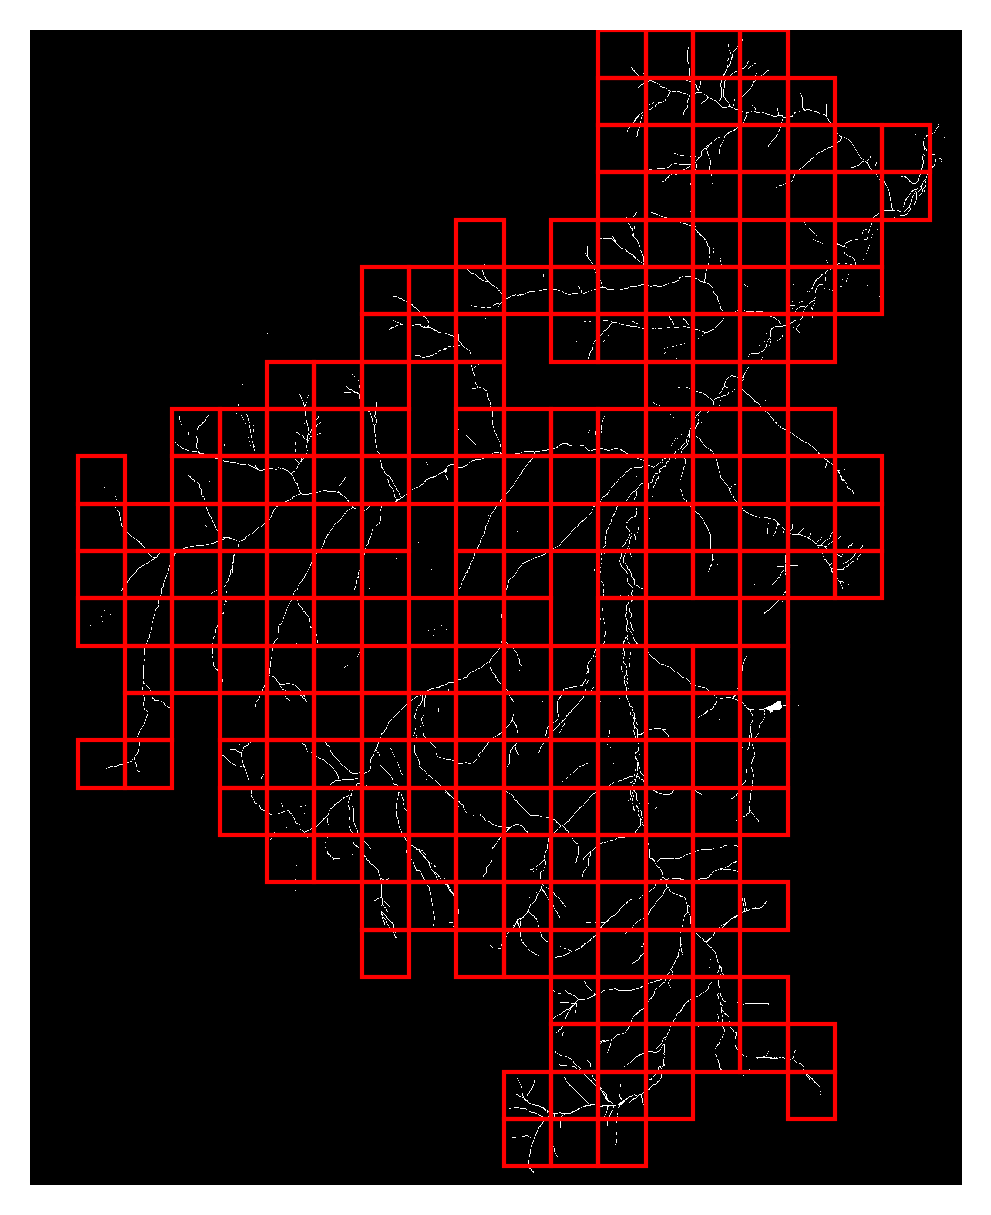

In [30]:
# Step 2: Plot the patches from the saved file
plot_patches_from_file(input_raster_path, huc_code, patch_size, dpi=300)

### 2. Data Extraction

After generating patches, we proceed to extract the data from each valid patch location and stack it into a multi-channel array. This array will serve as the input data for the machine learning model.

**Steps for Data Extraction**:
1. **Stack Raster Layers**: Load each raster layer for watershed `190603010302` and stack them together to create a multi-channel array. For instance, layers might include elevation models (DSM, DTM), hydrological indices (e.g., TWI), and surface characteristics (e.g., curvature).
2. **Extract Patches**: Use the patch locations saved from the previous step to extract each patch’s data from the multi-channel array.
3. **Save as Numpy Arrays**: For each patch, save the extracted data as `.npy` files, which are easy to load and process for machine learning models.

This data extraction step prepares the patches for direct input into models by organizing the data into standardized arrays, with each channel corresponding to a unique terrainations of the processed data.


#### Define the functions

In [54]:
import os
import numpy as np
import rasterio

def stack_tif_files(data_dir, huc_code, file_names):
    """
    Stack specified TIFF files to create an n-channel array.
    
    Args:
        data_dir (str): Directory containing the TIFF files.
        huc_code (str): Unique identifier for the watershed.
        file_names (list): List of file names (without path) to stack.

    Returns:
        np.ndarray: Stacked array with shape (height, width, n_channels).
    """
    channels = []
    invalid_mask = None  # To store an invalid mask if needed

    # Read and stack the TIFF files
    for file_name in file_names:
        file_path = os.path.join(data_dir, file_name)
        with rasterio.open(file_path) as src:
            # Read the first band
            tif_data = src.read(1)
            # Create an invalid mask for the first channel if needed
            if invalid_mask is None:
                invalid_mask = (tif_data == src.nodata) if src.nodata is not None else np.zeros_like(tif_data)
            # Normalize the data (assuming a normalize_tif function exists)
            normalized_data = normalize_tif(tif_data)
            channels.append(normalized_data)

    # Add the invalid mask as the last channel if necessary
    channels.append(invalid_mask)
    # Stack all channels into a single 3D array
    stacked_array = np.stack(channels, axis=-1)
    print(f"Stacked data has shape {stacked_array.shape}")
    return stacked_array

def normalize_tif(tif_data):
    """Normalize the TIFF data by ignoring -9999 values, replacing them with the mean, and scaling to 0-255 range."""
    # Mask -9999 values for mean and standard deviation calculation
    masked_data = np.ma.masked_values(tif_data, -9999)
    
    # Calculate mean and standard deviation of the valid data
    mean_val = masked_data.mean()
    min_val = masked_data.min()
    max_val = masked_data.max()
    
    # Replace -9999 values with the mean of the valid data
    tif_data = np.where(tif_data == -9999, mean_val, tif_data)

    # Scale data to the range 0-255, avoiding division by zero
    if max_val - min_val > 0:
        scaled_data = 255 * (tif_data - min_val) / (max_val - min_val)
    else:
        # If min and max are equal, return a flat array with mean value scaled to 255
        scaled_data = np.full_like(tif_data, 255 if mean_val > 0 else 0)

    return scaled_data.astype(np.uint8)


def extract_patches_from_stacked_and_reference(stacked_array, reference_file_path, patch_locations_path, patch_size, huc_code):
    """
    Extract patches from a stacked n-channel array and a reference file, saving as separate .npy files for data and labels.
    
    Args:
        stacked_array (np.ndarray): The n-channel stacked array (data).
        reference_file_path (str): Path to the reference TIFF file (labels).
        patch_locations_path (str): Path to the file with patch locations.
        patch_size (int): Size of each patch.
        huc_code (str): Unique identifier for the watershed, used in output file names.
    """
    data_patches = []   # List to store data patches
    label_patches = []  # List to store label patches

    # Load the reference (label) file
    with rasterio.open(reference_file_path) as ref_src:
        label_data = ref_src.read(1)  # Assuming single-band label data
                
        # Ensure binary labels: set anything greater than 0 to 1
        label_data = np.where(label_data > 0, 1, 0)

    # Read the patch locations from the file
    with open(patch_locations_path, 'r') as file:
        for line in file:
            x, y = map(int, line.strip().split(','))

            # Extract data patch from stacked array
            patch_data = stacked_array[y:y+patch_size, x:x+patch_size, :]
            
            # Extract label patch from reference data
            patch_label = label_data[y:y+patch_size, x:x+patch_size]

            # Check if the patches are fully within bounds
            if patch_data.shape == (patch_size, patch_size, stacked_array.shape[2]) and patch_label.shape == (patch_size, patch_size):
                data_patches.append(patch_data)   # Append data patch to list
                label_patches.append(patch_label) # Append label patch to list

    # Convert lists to single NumPy arrays
    data_array = np.stack(data_patches, axis=0)   # Shape: (number of patches, patch_size, patch_size, channels)
    label_array = np.stack(label_patches, axis=0) # Shape: (number of patches, patch_size, patch_size)

    # Save the final arrays as .npy files
    data_output_path = f"{huc_code}_data.npy"
    label_output_path = f"{huc_code}_label.npy"
    np.save(data_output_path, data_array)
    np.save(label_output_path, label_array)
    print(f"Data patches saved to {data_output_path} with shape {data_array.shape}")
    print(f"Label patches saved to {label_output_path} with shape {label_array.shape}")


In [55]:
# Usage example
data_dir = "data"  # Directory containing the TIFF files
huc_code = "190603010302"
patch_size = 128
patch_locations_path = f"{huc_code}.txt"  # Path to patch location file

# Specify file names for data files (excluding the reference file)
file_names = [
    f"curvature_{huc_code}.tif",
    f"swm1_{huc_code}.tif",
    f"swm2_{huc_code}.tif",
    f"ohswm1_{huc_code}.tif",
    f"dsm_{huc_code}.tif",
    f"geomorph_{huc_code}.tif",
    f"pos_openness_{huc_code}.tif",
    f"tpi_11_{huc_code}.tif",
    f"twi_{huc_code}.tif",
    f"tpi_3_{huc_code}.tif",
    f"dtm_{huc_code}.tif",
]

# Path to the reference file for labels
reference_file_path = os.path.join(data_dir, f"190603010302_filtered_ref_1m_minbuf.tif")  # Update this path if necessary

In [56]:
# Step 1: Stack the TIFF files
stacked_array = stack_tif_files(data_dir, huc_code, file_names)

Stacked data has shape (3123, 2519, 12)


In [57]:
# Step 2: Extract patches from the stacked array and save the output to npy file
extract_patches_from_stacked_and_reference(stacked_array, reference_file_path, patch_locations_path, patch_size, huc_code)

Data patches saved to 190603010302_data.npy with shape (222, 128, 128, 12)
Label patches saved to 190603010302_label.npy with shape (222, 128, 128)


#### Visualize the output

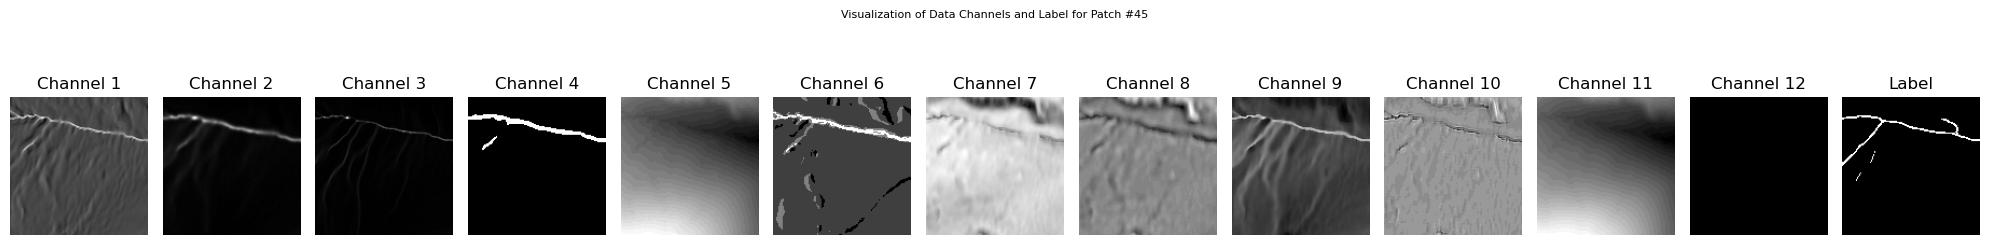

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_patches(data_file_path, label_file_path, sample_idx=15):
    """
    Visualize the data channels and label for a specific patch sample.
    
    Args:
        data_file_path (str): Path to the .npy file containing data patches.
        label_file_path (str): Path to the .npy file containing label patches.
        sample_idx (int): Index of the patch to visualize (default is 0).
    """
    # Load the data and label arrays
    data_array = np.load(data_file_path)   # Shape: (num_patches, patch_size, patch_size, channels)
    label_array = np.load(label_file_path) # Shape: (num_patches, patch_size, patch_size)
    
    # Extract the specific sample
    data_patch = data_array[sample_idx]    # Shape: (patch_size, patch_size, channels)
    label_patch = label_array[sample_idx]  # Shape: (patch_size, patch_size)

    num_channels = data_patch.shape[-1]  # Number of channels in the data patch

    # Plot each channel of the data patch
    fig, axes = plt.subplots(1, num_channels + 1, figsize=(20, 3))
    fig.suptitle(f"Visualization of Data Channels and Label for Patch #{sample_idx}", fontsize=8)

    # Plot each data channel
    for i in range(num_channels):
        axes[i].imshow(data_patch[:, :, i], cmap='gray')
        axes[i].set_title(f"Channel {i+1}")
        axes[i].axis('off')

    # Plot the label patch
    axes[num_channels].imshow(label_patch, cmap='gray')
    axes[num_channels].set_title("Label")
    axes[num_channels].axis('off')

    plt.tight_layout()
    plt.show()

# Usage example
data_file_path = "190603010302_data.npy"   # Path to the data .npy file
label_file_path = "190603010302_label.npy" # Path to the label .npy file

# Visualize the first sample (sample_idx=0)
visualize_patches(data_file_path, label_file_path, sample_idx=45)


## Example Usage


This section demonstrates how to use the prepared data and label patches to train a simple machine learning model for binary segmentation. Using a convolutional neural network (CNN), we’ll train the model to predict streamline locations based on the extracted data features. This example will walk through:

1. **Loading the Data and Labels**: We’ll start by loading the data and label patches from the `.npy` files created during the data extraction process.
2. **Splitting the Data**: The data will be split into training and validation sets to assess the model's performance.
3. **Building a CNN Model**: We’ll define a straightforward CNN architecture for binary segmentation.
4. **Training the Model**: The model will be trained on the data patches to learn the pattern of streamline vs. non-streamline areas.
5. **Evaluating and Visualizing Results**: Finally, we’ll evaluate the model and visualize its predictions to see how well it performs on the validation set.

This example provides a foundation for training more advanced models tailored to geospatial segmentation tasks, enabling you to expand upon this baseline for further analysis and research.
arning.


##### 1. Import Libraries

In [68]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose, Reshape, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

2024-11-05 19:30:23.789964: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 19:30:23.798372: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 19:30:23.814764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730835023.842238     199 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730835023.850554     199 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 19:30:23.884426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

##### 2. Load Data and Labels

In [69]:
# Load data and label patches
huc_code = "190603010302"  # Example HUC code
data_patches = np.load(f"{huc_code}_data.npy")  # Shape: (num_patches, patch_size, patch_size, channels)
label_patches = np.load(f"{huc_code}_label.npy")  # Shape: (num_patches, patch_size, patch_size)

print("Data patches shape:", data_patches.shape)
print("Label patches shape:", label_patches.shape)

# Reshape labels to match the expected output format for training
label_patches = label_patches[..., np.newaxis]  # Add a channel dimension, shape: (num_patches, patch_size, patch_size, 1)b

Data patches shape: (222, 128, 128, 12)
Label patches shape: (222, 128, 128)


##### 3. Split Data into Training and Validation Sets

In [70]:
# Split data and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_patches, label_patches, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)


Training data shape: (177, 128, 128, 12)
Validation data shape: (45, 128, 128, 12)


##### 4. Define a Simple CNN Model
This model uses convolutional layers to process the input data and predicts a binary segmentation map for each patch.

In [71]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        
        # Convolutional layers
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        
        # Upsample layers to bring output back to the original patch size
        Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'),
        Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same'),
        
        # Output layer with 1 filter for binary classification (streamline vs. non-streamline)
        Conv2D(1, (1, 1), activation='sigmoid', padding='same')
    ])
    return model

# Initialize the model
input_shape = X_train.shape[1:]  # Shape of a single patch, including channels
model = create_model(input_shape)
model.summary()


2024-11-05 19:30:39.685642: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,129 (734.88 KB)

 Trainable params: 188,129 (734.88 KB)

 Non-trainable params: 0 (0.00 B)

##### 5. Compile the Model
We use binary cross-entropy as the loss function, since this is a binary classification problem (streamline vs. non-streamline), and Adam as the optimizer.

In [72]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


##### 6. Train the Model
Train the model on the training data and validate on the validation set.

In [73]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16
)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 518ms/step - accuracy: 0.7333 - loss: 0.9072 - val_accuracy: 0.9266 - val_loss: 0.2737
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step - accuracy: 0.9390 - loss: 0.2405 - val_accuracy: 0.9266 - val_loss: 0.2492
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 599ms/step - accuracy: 0.9385 - loss: 0.2161 - val_accuracy: 0.9266 - val_loss: 0.2300
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 572ms/step - accuracy: 0.9302 - loss: 0.2245 - val_accuracy: 0.9271 - val_loss: 0.2205
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 556ms/step - accuracy: 0.9411 - loss: 0.1897 - val_accuracy: 0.9281 - val_loss: 0.2588
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 545ms/step - accuracy: 0.9427 - loss: 0.1905 - val_accuracy: 0.9290 - val_loss: 0.2365
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step - accuracy: 0.9455 - loss: 0.1708 - val_accuracy: 0.9292 - val_loss: 0.2366
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 510ms/step - accuracy: 0.9348 - loss: 0.1827 - val_accuracy: 0.

##### 7. Evaluate the Model
After training, evaluate the model's performance on the validation data.

In [74]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9384 - loss: 0.1575
Validation Loss: 0.1599, Validation Accuracy: 0.9380


##### 8. Visualize Predictions
Visualize a few predictions to see how well the model performs on the validation set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


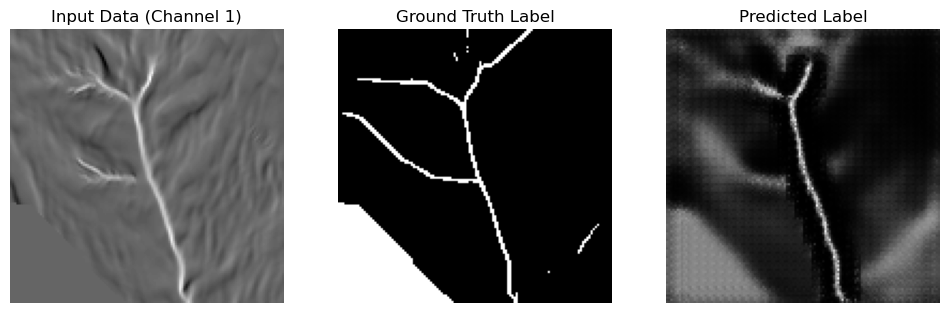

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


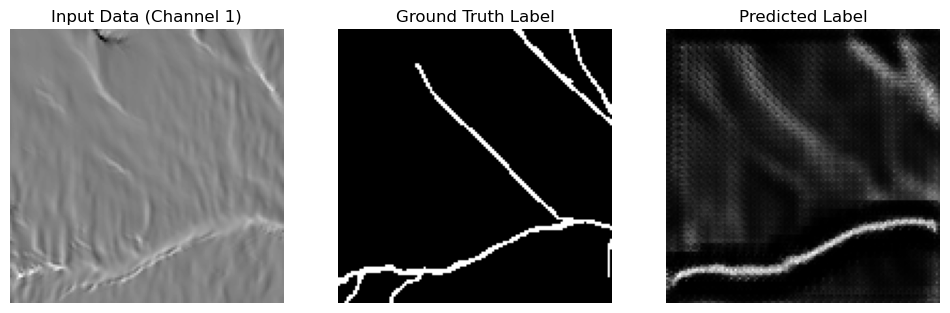

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


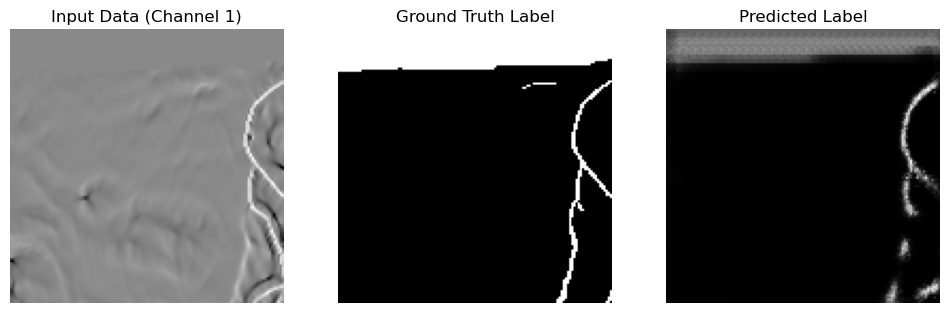

In [75]:
import matplotlib.pyplot as plt

# Select a few samples from the validation set
num_samples = 3
for i in range(num_samples):
    sample_data = X_val[i]
    sample_label = y_val[i]
    prediction = model.predict(sample_data[np.newaxis, ...])[0]  # Predict for a single sample
    
    plt.figure(figsize=(12, 4))

    # Display input data (first channel)
    plt.subplot(1, 3, 1)
    plt.imshow(sample_data[:, :, 0], cmap='gray')
    plt.title("Input Data (Channel 1)")
    plt.axis('off')

    # Display ground truth label
    plt.subplot(1, 3, 2)
    plt.imshow(sample_label[:, :, 0], cmap='gray')
    plt.title("Ground Truth Label")
    plt.axis('off')

    # Display predicted label
    plt.subplot(1, 3, 3)
    plt.imshow(prediction[:, :, 0], cmap='gray')
    plt.title("Predicted Label")
    plt.axis('off')

    plt.show()
